Loaded meta_train.csv. Shape: (10407, 4)


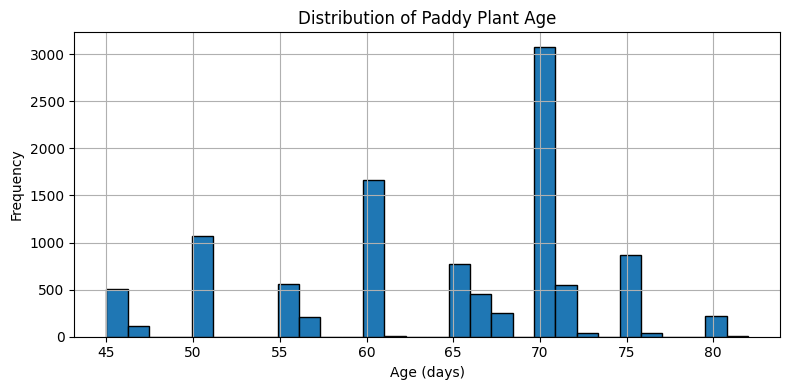

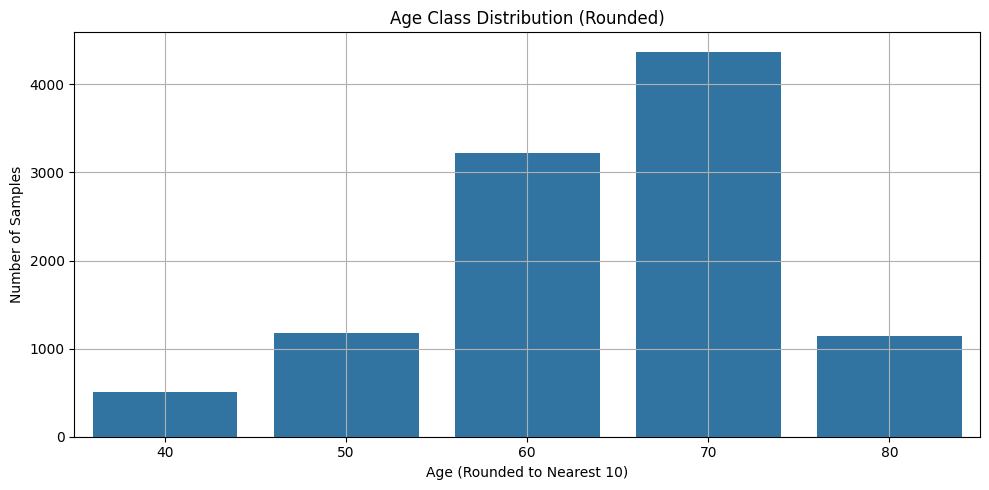

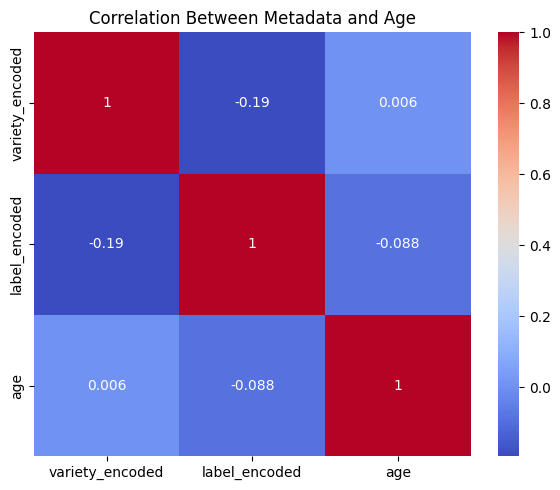

Found image: 100330.jpg
Original size: (480, 640)


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# === Future-Proof Path Setup === #
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

PATHS = {
    "csv": os.path.join(BASE_PATH, "meta_train.csv"),
    "train_images": os.path.join(BASE_PATH, "dataset", "train"),
    "val_images": os.path.join(BASE_PATH, "dataset", "val"),  # Optional for later use
    "test_images": os.path.join(BASE_PATH, "test_images"),
}

os.makedirs(PATHS["output_dir"], exist_ok=True)

# === Load Data === #
df = pd.read_csv(PATHS["csv"])
print("Loaded meta_train.csv. Shape:", df.shape)

# === Plot Age Distribution === #
plt.figure(figsize=(8, 4))
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Distribution of Paddy Plant Age')
plt.xlabel('Age (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Age Distribution Cleanly === #
df['age_class'] = df['age'].round(-1).astype(int)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='age_class', order=sorted(df['age_class'].unique()))
plt.title("Age Class Distribution (Rounded)")
plt.xlabel("Age (Rounded to Nearest 10)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


# === Correlation Heatmap === #
df['variety_encoded'] = df['variety'].astype('category').cat.codes
df['label_encoded'] = df['label'].astype('category').cat.codes

plt.figure(figsize=(6, 5))
sns.heatmap(df[['variety_encoded', 'label_encoded', 'age']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Metadata and Age')
plt.tight_layout()
plt.show()

from pathlib import Path
from PIL import Image

sample_image_id = df['image_id'].iloc[0]  # e.g., '100330.jpg'
found_path = None

# Recursively search for the image in all subfolders of train_images/
for root, dirs, files in os.walk(PATHS["train_images"]):
    if sample_image_id in files:
        found_path = os.path.join(root, sample_image_id)
        break

if found_path:
    img = Image.open(found_path)
    print(f"Found image: {sample_image_id}")
    print(f"Original size: {img.size}")
    img.show()
else:
    print(f"Image {sample_image_id} not found in any subfolder of train_images/")


In [41]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import albumentations as A
import random

# === CONFIG ===
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

PATHS = {
    "train_images": os.path.join(BASE_PATH, "dataset", "train"),
    "augmented_images": os.path.expanduser("~/Desktop/augmented_images"),
    "augmented_csv": os.path.expanduser("~/Desktop/meta_aug_train.csv"),
    "meta_csv": os.path.join(BASE_PATH, "meta_train.csv")
}


os.makedirs(PATHS["augmented_images"], exist_ok=True)

# === Load Original CSV ===
df = pd.read_csv(PATHS["meta_csv"])
df['variety_encoded'] = df['variety'].astype('category').cat.codes

# === Step 1: Bin age
df['age_bin'] = pd.cut(df['age'], bins=5, labels=False)

# === Step 2: Apply SMOTE on (age, variety), stratified by age_bin
X = df[['age', 'variety_encoded']].values
y = df['age_bin'].values
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# === Step 3: Build resampled DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['age', 'variety_encoded'])
df_resampled['age_bin'] = y_resampled

# === Step 4: Decode variety
variety_map = dict(enumerate(df['variety'].astype('category').cat.categories))
df_resampled['variety'] = df_resampled['variety_encoded'].map(variety_map)

# === Step 5: Map age_bin to image_ids
df_original = df[['image_id', 'age_bin']]  # only needed columns
bin_to_images = df_original.groupby("age_bin")['image_id'].apply(list).to_dict()

assigned_ids = []
for _, row in df_resampled.iterrows():
    bin_id = row['age_bin']
    candidates = bin_to_images.get(bin_id, [])
    assigned_ids.append(random.choice(candidates) if candidates else None)

df_resampled['image_id'] = assigned_ids

# === Step 6: Define Augmentation Pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomCrop(width=224, height=224),
    A.Resize(256, 256)
])

# === Step 7: Generate Augmented Images
augmented_records = []

for i, row in tqdm(df_resampled.iterrows(), total=len(df_resampled)):
    image_filename = row.get('image_id')
    if image_filename is None:
        continue

    # Find image path
    image_path = None
    for root, dirs, files in os.walk(PATHS["train_images"]):
        if image_filename in files:
            image_path = os.path.join(root, image_filename)
            break
    if image_path is None:
        continue

    try:
        image = np.array(Image.open(image_path).convert("RGB"))
    except Exception as e:
        print(f"❌ Failed to load {image_path}: {e}")
        continue

    transformed = transform(image=image)['image']
    new_filename = f"aug_{i}_{image_filename}"
    save_path = os.path.join(PATHS["augmented_images"], new_filename)
    Image.fromarray(transformed).save(save_path)

    augmented_records.append({
        'image_id': new_filename,
        'variety': row['variety'],
        'age': row['age']
    })

# === Step 8: Save Metadata CSV
df_augmented = pd.DataFrame(augmented_records)
df_augmented.to_csv(PATHS["augmented_csv"], index=False)
print(f"✅ Augmented {len(df_augmented)} images saved to: {PATHS['augmented_images']}")
print(f"✅ Metadata saved to: {PATHS['augmented_csv']}")


/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
100%|████████████████████████████████████| 19600/19600 [01:44<00:00, 188.43it/s]

✅ Augmented 15617 images saved to: /Users/anluu/Desktop/augmented_images
✅ Metadata saved to: /Users/anluu/Desktop/meta_aug_train.csv


/var/folders/l_/2tbf5tf961vg06w5znf_dhnr0000gn/T/ipykernel_8394/820795088.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


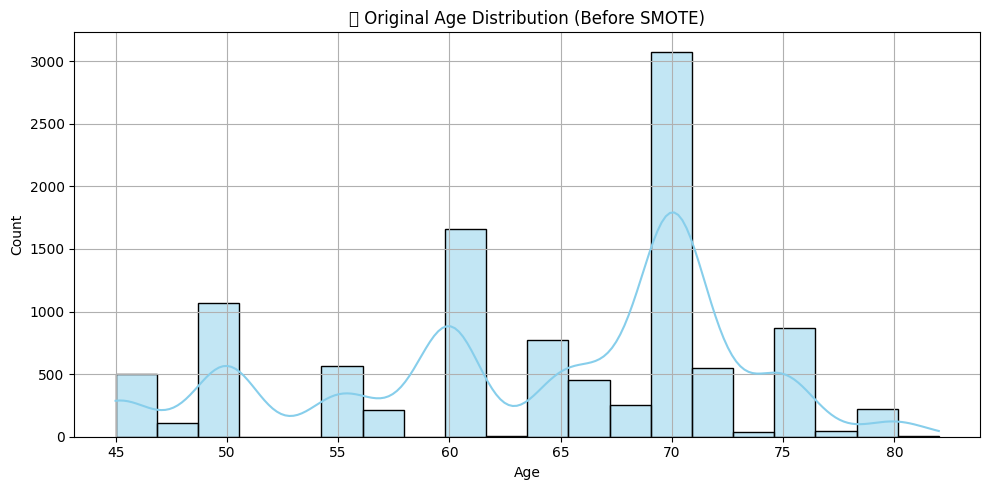

/var/folders/l_/2tbf5tf961vg06w5znf_dhnr0000gn/T/ipykernel_8394/820795088.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


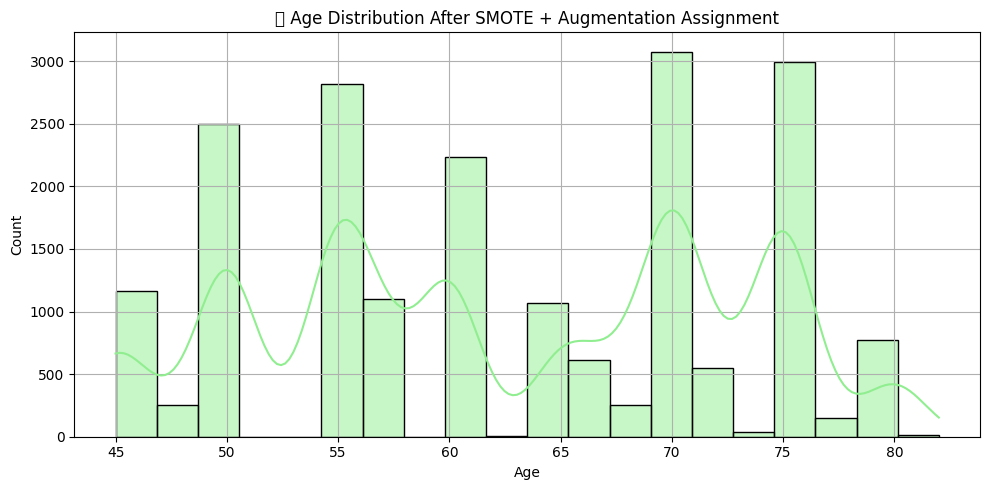

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Before: Original Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=20, kde=True, color="skyblue")
plt.title("📉 Original Age Distribution (Before SMOTE)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# === After: Resampled Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_resampled['age'], bins=20, kde=True, color="lightgreen")
plt.title("📈 Age Distribution After SMOTE + Augmentation Assignment")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# === CONFIG: adjust paths ===
IMG_DIR_ORIG = os.path.expanduser("~/Desktop/full_dataset/train")
IMG_DIR_AUG = os.path.expanduser("~/Desktop/augmented_images")           
META_TRAIN_CSV = os.path.expanduser("~/Desktop/meta_train.csv")
META_AUG_CSV = os.path.expanduser("~/Desktop/meta_aug_train.csv")

# === Step 1: Load CSVs
df_orig = pd.read_csv(META_TRAIN_CSV)
df_aug = pd.read_csv(META_AUG_CSV)

df_orig['filename'] = df_orig['image_id']
df_aug['filename'] = df_aug['image_id']

df_aug['label'] = df_aug['variety']  # ✅ Add this line

# === Step 2: Add full path
def get_path(row):
    if row['filename'].startswith('aug_'):
        # Augmented images are saved in a flat folder
        return os.path.join(IMG_DIR_AUG, row['filename'])
    else:
        # Original images are inside train/<label>/<filename>
        return os.path.join(IMG_DIR_ORIG, row['label'], row['filename'])


df_orig['full_path'] = df_orig.apply(get_path, axis=1)
df_aug['full_path'] = df_aug.apply(get_path, axis=1)


df_orig['full_path'] = df_orig.apply(get_path, axis=1)
df_aug['full_path'] = df_aug.apply(get_path, axis=1)

# === Step 3: Combine for training
df_combined = pd.concat([df_orig, df_aug], ignore_index=True)

# === Step 4: Train/Val split
df_train, df_val = train_test_split(df_combined, test_size=0.2, random_state=42)

# === Step 5: Check for missing files
missing_train = df_train[~df_train['full_path'].apply(os.path.exists)]
missing_val = df_val[~df_val['full_path'].apply(os.path.exists)]

print(f"❌ Missing training files: {missing_train.shape[0]}")
print(f"❌ Missing validation files: {missing_val.shape[0]}")
print("🔍 Example missing val paths:")
print(missing_val[['filename', 'full_path']].head())

# === Step 6: Remove missing
df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

# === Step 7: Fallback if val is empty
if df_val.empty:
    print("⚠️ WARNING: df_val is empty after filtering! Retrying split...")
    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
    df_train['full_path'] = df_train.apply(get_path, axis=1)
    df_val['full_path'] = df_val.apply(get_path, axis=1)
    df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
    df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

print("✅ Final Train shape:", df_train.shape)
print("✅ Final Val shape:", df_val.shape)


❌ Missing training files: 1649
❌ Missing validation files: 433
🔍 Example missing val paths:
        filename                                          full_path
2583  108538.jpg  /Users/anluu/Desktop/full_dataset/train/blast/...
7639  105055.jpg  /Users/anluu/Desktop/full_dataset/train/normal...
7428  106229.jpg  /Users/anluu/Desktop/full_dataset/train/hispa/...
8880  108652.jpg  /Users/anluu/Desktop/full_dataset/train/normal...
1227  105360.jpg  /Users/anluu/Desktop/full_dataset/train/blast/...
✅ Final Train shape: (19170, 6)
✅ Final Val shape: (4772, 6)


✅ Final Train shape: (19170, 6)
✅ Final Val shape: (4772, 6)
Found 19170 validated image filenames.
Found 4772 validated image filenames.


2025-06-05 09:46:27.475591: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-05 09:46:27.475624: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-05 09:46:27.475631: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-05 09:46:27.475685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-05 09:46:27.475718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-06-05 09:46:29.373327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - ETA: 0s - loss: 0.1015 - mae: 0.3574 - rmse: 0.4495 - r_squared: -2.1201

2025-06-05 09:48:16.450629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - 116s 190ms/step - loss: 0.1015 - mae: 0.3574 - rmse: 0.4495 - r_squared: -2.1201 - val_loss: 0.1038 - val_mae: 0.3867 - val_rmse: 0.4533 - val_r_squared: -2.2852
Epoch 2/50
600/600 [==============================] - 113s 189ms/step - loss: 0.0930 - mae: 0.3447 - rmse: 0.4291 - r_squared: -1.8698 - val_loss: 0.0677 - val_mae: 0.3090 - val_rmse: 0.3659 - val_r_squared: -1.1303
Epoch 3/50
600/600 [==============================] - 112s 186ms/step - loss: 0.0908 - mae: 0.3407 - rmse: 0.4232 - r_squared: -1.7687 - val_loss: 0.0435 - val_mae: 0.2515 - val_rmse: 0.2932 - val_r_squared: -0.3516
Epoch 4/50
600/600 [==============================] - 111s 185ms/step - loss: 0.0915 - mae: 0.3412 - rmse: 0.4257 - r_squared: -1.7954 - val_loss: 0.0351 - val_mae: 0.2324 - val_rmse: 0.2635 - val_r_squared: -0.0804
Epoch 5/50
600/600 [==============================] - 111s 185ms/step - loss: 0.0918 - mae: 0.3428 - rmse: 0.4265 - r_squared: -1.8712 - val_loss: 

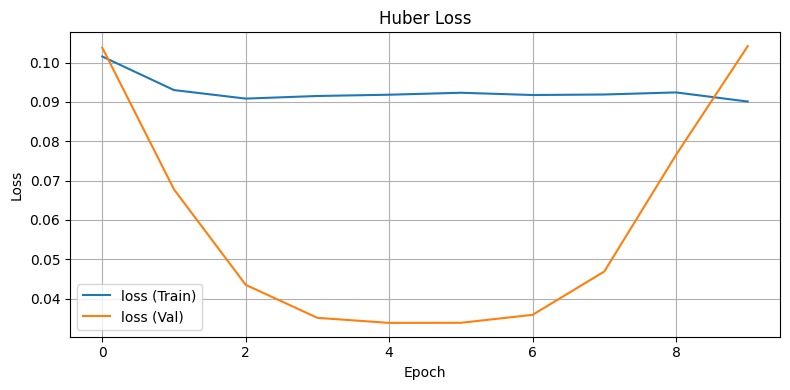

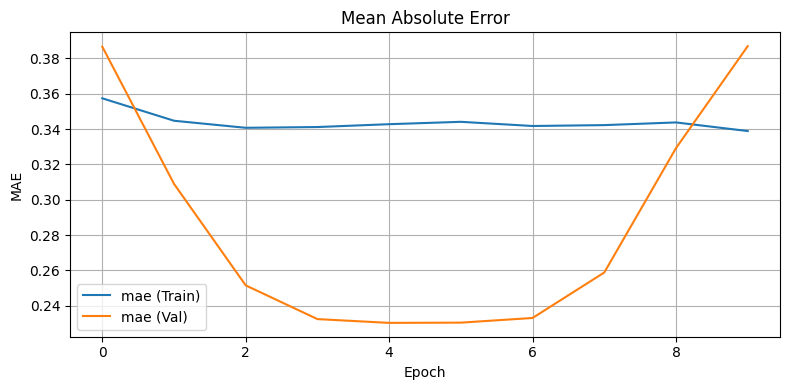

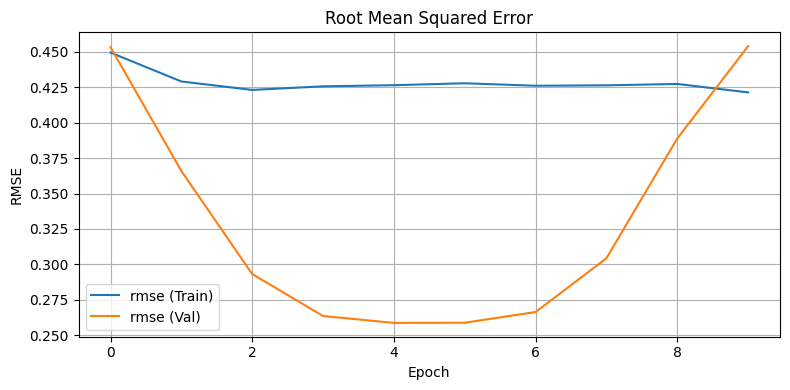

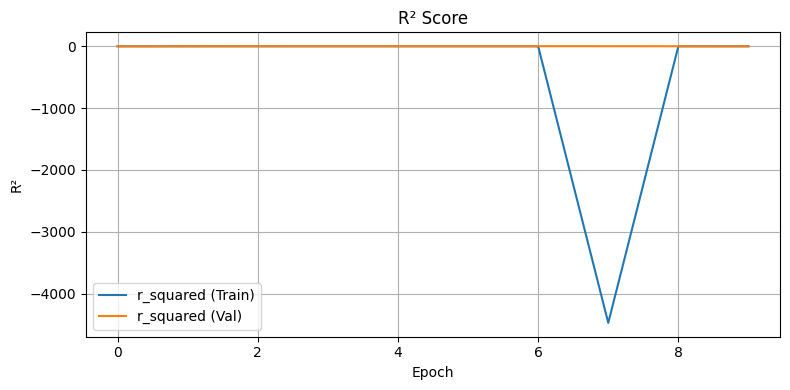

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow.keras.backend as K

# === CONFIG ===
OUTPUT_DIR = "outputs_final"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 50

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Assume df_train, df_val are already defined
# Normalize age to [0, 1]
scaler = MinMaxScaler()
df_train['age'] = scaler.fit_transform(df_train[['age']])
df_val['age'] = scaler.transform(df_val[['age']])

# Filter out any missing paths
df_train = df_train[df_train['full_path'].apply(os.path.exists)].copy()
df_val = df_val[df_val['full_path'].apply(os.path.exists)].copy()

print("✅ Final Train shape:", df_train.shape)
print("✅ Final Val shape:", df_val.shape)

# === Data Generators (no augmentation)
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='full_path',
    y_col='age',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# === Custom Metrics
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# === Build Model
base = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
base.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(1)(x)

lr_schedule = CosineDecay(initial_learning_rate=1e-4, decay_steps=1000, alpha=1e-6)

model = Model(inputs=base.input, outputs=out)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=Huber(),
    metrics=['mae', rmse, r_squared]
)

# === Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

# === Plot Results
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric_name], label=f"{metric_name} (Train)")
    plt.plot(history.history[f"val_{metric_name}"], label=f"{metric_name} (Val)")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{metric_name}.png"))
    plt.show()

plot_metric('loss', 'Huber Loss', 'Loss')
plot_metric('mae', 'Mean Absolute Error', 'MAE')
plot_metric('rmse', 'Root Mean Squared Error', 'RMSE')
plot_metric('r_squared', 'R² Score', 'R²')
